---
title: Domains
---

In [1]:
import autoroot
import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp
import equinox as eqx
import finitediffx as fdx
from jaxtyping import Array, Float
# from jaxsw._src.domain.base import Domain
from jaxsw._src.domain.base_v2 import Domain, init_domain_1d
import math
# from jaxsw._src.fields.base import Field
from jaxsw import Field, FDField, SpectralField
from jaxsw._src.operators.functional import finitediff as F_fd
from jaxsw._src.operators.functional import spectral as F_spectral
import seaborn as sns

jax.config.update("jax_enable_x64", True)
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%load_ext autoreload
%autoreload 2

## Data

$$
u = x^2 + y^3 \\
v = x^4 + y^3
$$

In [2]:
xmin = -5.2
xmax = 10.5
Nx = 40.0
Lx = 21.5
dx = 1.0

In [3]:
x_domain = init_domain_1d(-1.0, 1.0, 100)
y_domain = init_domain_1d(-1.0, 1.0, 20)
x_domain.coords.shape, x_domain.Nx, y_domain.coords.shape, y_domain.Nx

((100, 1), (100,), (20, 1), (20,))

In [4]:
x_domain[1:-1]

Domain(
  xmin=(-0.9797979797979799,),
  xmax=(0.9797979797979799,),
  dx=(0.020202020202020204,),
  Nx=(98,),
  Lx=(1.96,),
  ndim=1
)

In [5]:
yx_domain = y_domain * x_domain
yx_domain

Domain(
  xmin=(-1.0, -1.0),
  xmax=(1.0, 1.0),
  dx=(0.10526315789473684, 0.020202020202020204),
  Nx=(20, 100),
  Lx=(2.0, 2.0),
  ndim=2
)

In [6]:
yx_domain[1:-1,1:-1]

Domain(
  xmin=(-0.8947368421052633, -0.9797979797979799),
  xmax=(0.894736842105263, 0.9797979797979799),
  dx=(0.10526315789473684, 0.020202020202020204),
  Nx=(18, 98),
  Lx=(1.8, 1.96),
  ndim=2
)

## Example 1: 1D Curve

$$
u(x) = \sin(2x) + \frac{1}{2}\cos(5x)
$$

In [7]:
f = lambda x: jnp.sin(2*x) + 0.5*jnp.cos(5*x)
df = jax.grad(f)
d2f = jax.grad(df)

In [8]:

Nx = 32
Lx = 2*math.pi
dx = Lx / Nx

# initialize domains
domain = Domain(xmin=0, xmax=Lx, dx=dx, Lx=Lx, Nx=Nx)
domain_plot = Domain(xmin=0, xmax=Lx, dx=0.1 * Lx / 10*Nx, Lx=Lx, Nx=10*Nx)

# initialize fields
u: Field = Field(values=f(domain.coords.squeeze()), domain=domain)
u_plot: Field = Field(values=f(domain_plot.coords.squeeze()), domain=domain_plot)

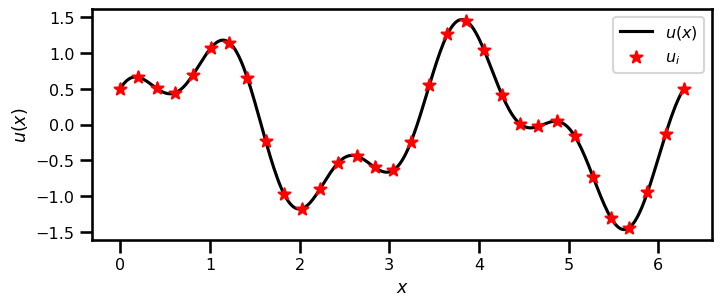

In [9]:
fig, ax = plt.subplots(figsize=(8,3))

ax.plot(u_plot.domain.coords, u_plot[:], linestyle="-", color="black", label=f"$u(x)$")
ax.scatter(u.domain.coords, u[:], color="r", marker="*", label=f"$u_i$", zorder=3)
ax.set(xlabel=r"$x$", ylabel=r"$u(x)$")
plt.legend()
plt.show()

### 1st Derivative

In [10]:
df = lambda x: (2.0 * jnp.cos(2.0 * x) - 2.5 * jnp.sin(5.0 * x)).squeeze()

In [11]:
dudx_plot = jax.vmap(df)(u_plot.domain.coords.squeeze())
dudx_analytical = jax.vmap(df)(u.domain.coords)

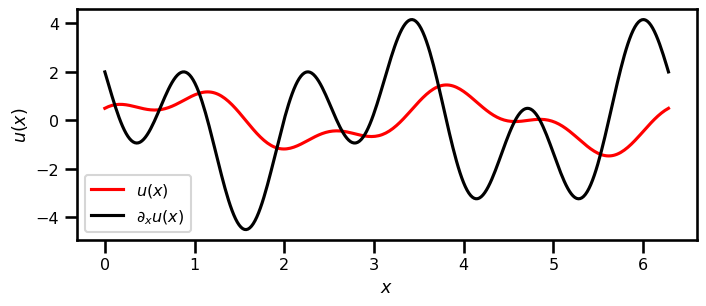

In [12]:
fig, ax = plt.subplots(figsize=(8,3))

ax.plot(u_plot.domain.coords, u_plot[:], linestyle="-", color="red", label=f"$u(x)$")
ax.plot(u_plot.domain.coords, dudx_plot, linestyle="-", color="black", label=f"$\partial_x u(x)$")
ax.set(xlabel=r"$x$", ylabel=r"$u(x)$")
plt.legend()
plt.show()

#### Finite Difference

::: {tip} Under the Hood (Functional API)
:class: dropdown


```python
# initialize domain
domain: Domain = ...
u: Array = ...

# calculate frequencies
k_vec = F_spectral.calculate_fft_freq(domain.Nx[0], domain.Lx[0])

# calculate the derivative
dudx_sp = F_spectral.difference(u=u, k_vec=k_vec, axis=0, derivative=1, real=True)

```

:::

In [32]:


# create finite difference field
u_fd = FDField(u[:], domain=u.domain)

# do finite difference
dudx_fd = F_fd.difference(u_fd, axis=0, derivative=1, accuracy=5, method="central")

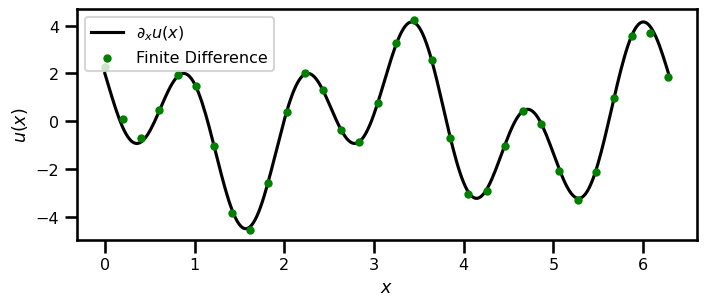

In [33]:
fig, ax = plt.subplots(figsize=(8,3))

ax.plot(u_plot.domain.coords, dudx_plot, linestyle="-", color="black", label=f"$\partial_x u(x)$")
ax.scatter(dudx_fd.domain.coords, dudx_fd[:], color="green", marker=".", label=f"Finite Difference", zorder=3)
ax.set(xlabel=r"$x$", ylabel=r"$u(x)$")
plt.legend()
plt.show()

#### Pseudospectral



::: {tip} Under the Hood (Individual Functions)
:class: dropdown

We need to create the vectors


$$
k = 
\left[ 
0, 1, 2, 3, \ldots, \frac{N_x}{2}, \frac{N_x}{2} + 1,
-\frac{N_x}{2}, -\frac{N_x}{2} + 2, \ldots, -3,  -2, -1
\right]
$$

```python
k1 = jnp.arange(0, Nx/2)
k2 = jnp.arange(-Nx/2, 0)
k = (2.0 * jnp.pi / Lx ) * jnp.concatenate([k1, k2], axis=0)
```

We do the forward FFT transformation.
We divide by the scaler value.

```python
# Forward FFT transform
fh = jnp.fft.fft(u)/Nx
```
We now do the multiplicative difference operator

```python
# difference operator
dfh_dx = 1j * k * fh
```

We do the inverse FFT transformation

```python
# inverse FFT transform
du_dx = jnp.fft.ifft(dfh_dx)
```

We remove the complex values and we rescale


```python
# remove excess
dudx_sp = jnp.real( du_dx * Nx)
```

:::

::: {tip} Under the Hood (From Scratch)
:class: dropdown


```python
# calculate frequencies
k_vec = F_spectral.calculate_fft_freq(Nx, Lx)

# forward transformation
Fu = F_spectral.fft_transform(u, axis=0, scale=Nx, inverse=False)

# difference operator
dFudx = F_spectral.spectral_difference(Fu, k_vec, axis=0, derivative=1)

# # inverse transformation
dudx_sp = F_spectral.fft_transform(dFudx, axis=0, scale=Nx, inverse=True)

dudx_sp = jnp.real(dudx_sp)

```

:::

::: {tip} Under the Hood (Functional API)
:class: dropdown


```python
# initialize domain
domain: Domain = ...
u: Array = ...

# calculate frequencies
k_vec = F_spectral.calculate_fft_freq(domain.Nx[0], domain.Lx[0])

# calculate the derivative
dudx_sp = F_spectral.difference(u=u, k_vec=k_vec, axis=0, derivative=1, real=True)

```

:::

In [34]:
# initialize field
u_spectral = SpectralField(values=u[:], domain=u.domain)

# derivative
dudx_spectral = F_spectral.difference_field(u=u_spectral, axis=0, derivative=1, real=True)


In [35]:
dudx_spectral

SpectralField(
  values=f64[32],
  domain=Domain(
    xmin=(0,),
    xmax=(6.283185307179586,),
    dx=(0.19634954084936207,),
    Nx=(32,),
    Lx=(6.283185307179586,),
    ndim=1
  )
)

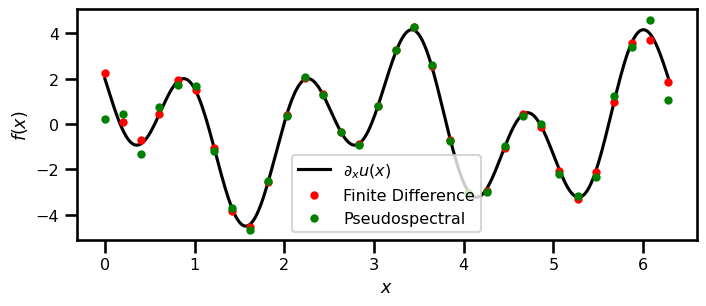

In [36]:
fig, ax = plt.subplots(figsize=(8,3))

ax.plot(u_plot.domain.coords, dudx_plot, linestyle="-", color="black", label=f"$\partial_x u(x)$")
ax.scatter(dudx_fd.domain.coords, dudx_fd[:], color="red", marker=".", label=f"Finite Difference", zorder=3)
ax.scatter(
    dudx_spectral.domain.coords.squeeze(), dudx_spectral[:], color="green", marker=".", label=f"Pseudospectral", zorder=3)
ax.set(xlabel=r"$x$", ylabel=r"$f(x)$")
plt.legend()
plt.show()

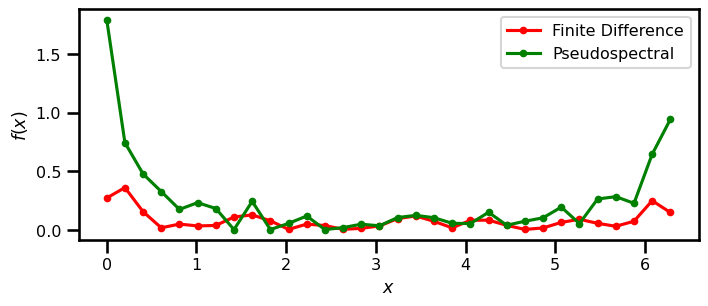

In [37]:
fig, ax = plt.subplots(figsize=(8,3))

fd_error = np.abs(dudx_fd[:] - dudx_analytical[:])
ps_error = np.abs(dudx_spectral[:] - dudx_analytical[:])

ax.plot(u.domain.coords, fd_error, color="red", marker=".", label=f"Finite Difference", zorder=3)
ax.plot(u.domain.coords, ps_error, color="green", marker=".", label=f"Pseudospectral", zorder=3)
ax.set(xlabel=r"$x$", ylabel=r"$f(x)$")
plt.legend()
plt.show()

### 2nd Derivative

In [38]:
d2udx2_plot = jax.vmap(d2f)(u_plot.domain.coords.squeeze())
d2udx2_analytical = jax.vmap(d2f)(u.domain.coords.squeeze())

#### Finite Difference

In [39]:
# create finite difference field
u_fd = FDField(u[:], domain=u.domain)

# do finite difference
d2udx2_fd = F_fd.difference(u_fd, axis=0, derivative=2, accuracy=5, method="central")

#### Pseudospectral

In [43]:
# initialize field
u_spectral = SpectralField(values=u[:], domain=u.domain)

# derivative
d2udx2_spectral = F_spectral.difference_field(u=u_spectral, axis=0, derivative=2, real=True)


#### Viz: Derivatives

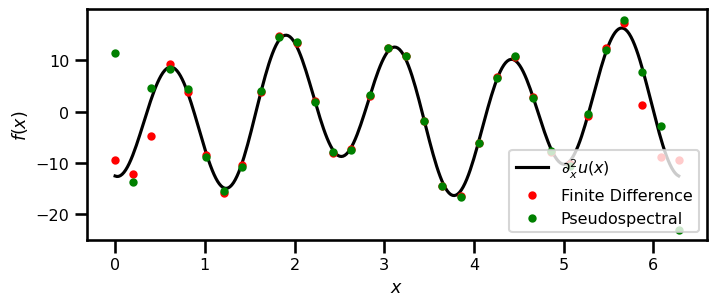

In [45]:
fig, ax = plt.subplots(figsize=(8,3))

ax.plot(u_plot.domain.coords, d2udx2_plot, linestyle="-", color="black", label=f"$\partial^2_x u(x)$")
ax.scatter(d2udx2_fd.domain.coords, d2udx2_fd[:], color="red", marker=".", label=f"Finite Difference", zorder=3)
ax.scatter(
    d2udx2_spectral.domain.coords.squeeze(), d2udx2_spectral[:], color="green", marker=".", label=f"Pseudospectral", zorder=3)
ax.set(xlabel=r"$x$", ylabel=r"$f(x)$")
plt.legend()
plt.show()

#### Visualization: Numerical Error

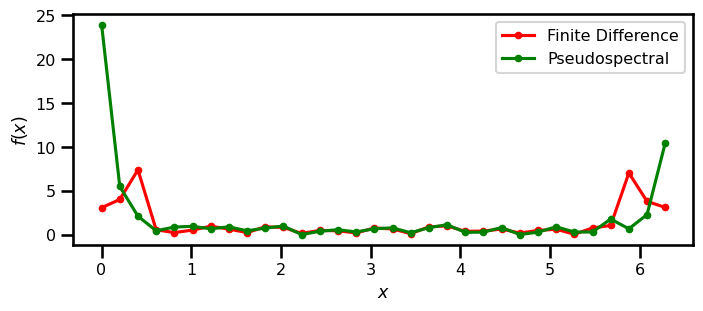

In [42]:
fig, ax = plt.subplots(figsize=(8,3))

fd_error = np.abs(d2udx2_fd[:] - d2udx2_analytical[:])
ps_error = np.abs(d2udx2_spectral[:] - d2udx2_analytical[:])

ax.plot(u.domain.coords, fd_error, color="red", marker=".", label=f"Finite Difference", zorder=3)
ax.plot(u.domain.coords, ps_error, color="green", marker=".", label=f"Pseudospectral", zorder=3)
ax.set(xlabel=r"$x$", ylabel=r"$f(x)$")
plt.legend()
plt.show()

## Example 2: 2D Scalar Field

$$
u(x,y) = \cos \left(m_x \frac{2\pi}{L_x}x \right) \sin \left(m_y \frac{2\pi}{L_y}y \right)
$$

In [159]:
def f(x, y, Lx, Ly, mx, my):
    return jnp.cos(mx* 2 * jnp.pi * x / Lx) * jnp.sin(my * 2*jnp.pi*y / Ly)

# define gradient functions
df_dx = jax.grad(f, argnums=0)
df_dy = jax.grad(f, argnums=1)

In [168]:
mx, my = 3, 2
Nx, Ny = 64, 32
# Lx, Ly = 2.0*jnp.pi, 2.0*jnp.pi
Lx, Ly = 2*math.pi, 2*math.pi
dx, dy = Lx/Nx, Ly/Ny

# create individual domains
x_domain = Domain(xmin=0, xmax=Lx-dx, Lx=Lx, Nx=Nx, dx=dx)
y_domain = Domain(xmin=0, xmax=Ly-dx, Lx=Ly, Nx=Ny, dx=dy)

# create joint domain
xy_domain = x_domain * y_domain

In [169]:

kernel = lambda x,y: f(x,y,Lx,Ly,mx,my)
kernel_grad_x = lambda x,y: df_dx(x,y,Lx,Ly,mx,my)
kernel_grad_y = lambda x,y: df_dy(x,y,Lx,Ly,mx,my)

def gram_matrix(f, x, y):
    return jax.vmap(lambda x: jax.vmap(lambda y: f(x, y))(y))(x)

x_coords, y_coords = xy_domain.coords_axis

u_true = gram_matrix(kernel, x_coords, y_coords)
du_dx_true = gram_matrix(kernel_grad_x, x_coords, y_coords)
du_dy_true = gram_matrix(kernel_grad_y, x_coords, y_coords)

# create fields
u: Field = Field(values=u_true, domain=xy_domain)
dudx: Field = Field(values=du_dx_true, domain=xy_domain)
dudy: Field = Field(values=du_dy_true, domain=xy_domain)

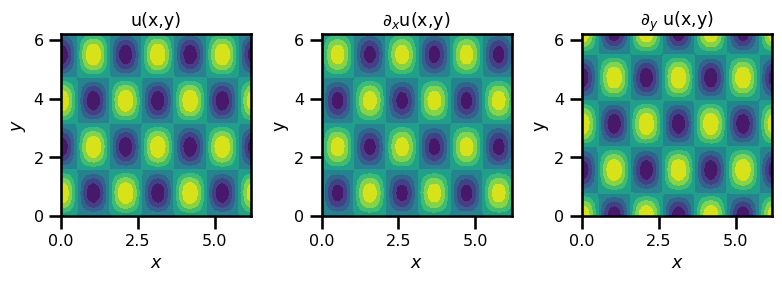

In [170]:
fig, ax = plt.subplots(ncols=3, figsize=(8,3))

X, Y = u.domain.grid_axis

ax[0].contourf(X, Y, u[:],)
ax[1].contourf(X, Y, dudx[:])
ax[2].contourf(X, Y, dudy[:])

ax[0].set(title="u(x,y)", xlabel="$x$", ylabel="$y$")
ax[1].set(title="$\partial_x $u(x,y)", xlabel="$x$", ylabel=r"y")
ax[2].set(title="$\partial_y$ u(x,y)", xlabel="$x$", ylabel="y")
plt.tight_layout()
plt.show()

#### Finite Difference

In [171]:
# create finite difference field
u_fd = FDField(u[:], domain=u.domain)

# do finite difference
dudx_fd = F_fd.difference(u_fd, axis=0, derivative=1, accuracy=5, method="central")
dudy_fd = F_fd.difference(u_fd, axis=1, derivative=1, accuracy=5, method="central")

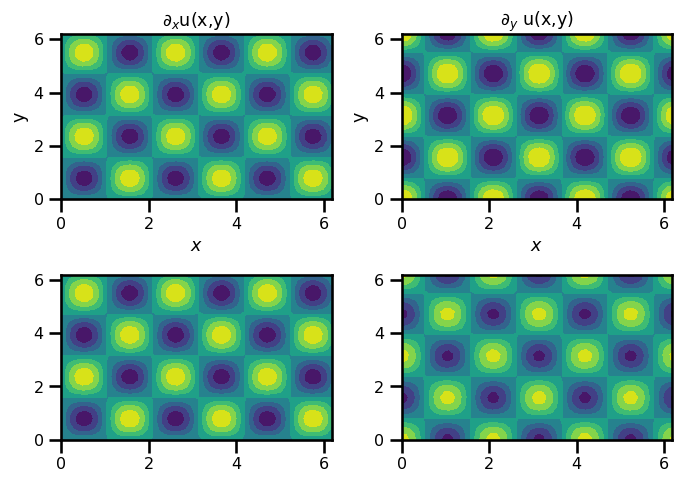

In [172]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(7,5))

x_levels = np.linspace(dudx[:].min(), dudx[:].max(), 6)
y_levels = np.linspace(dudy[:].min(), dudy[:].max(), 6)


ax[0,0].contourf(X, Y, dudx[:])
ax[0,1].contourf(X, Y, dudy[:])

X, Y = dudx_fd.domain.grid_axis

ax[1,0].contourf(X, Y, dudx_fd[:])
ax[1,1].contourf(X, Y, dudy_fd[:])

ax[0,0].set(title="$\partial_x $u(x,y)", xlabel="$x$", ylabel=r"y")
ax[0,1].set(title="$\partial_y$ u(x,y)", xlabel="$x$", ylabel="y")
plt.tight_layout()
plt.show()

#### Pseudospectral

In [173]:
# initialize field
u_spectral = SpectralField(values=u[:], domain=u.domain)

# derivative
dudx_spectral = F_spectral.difference_field(u=u_spectral, axis=0, derivative=1, real=True)
dudy_spectral = F_spectral.difference_field(u=u_spectral, axis=1, derivative=1, real=True)


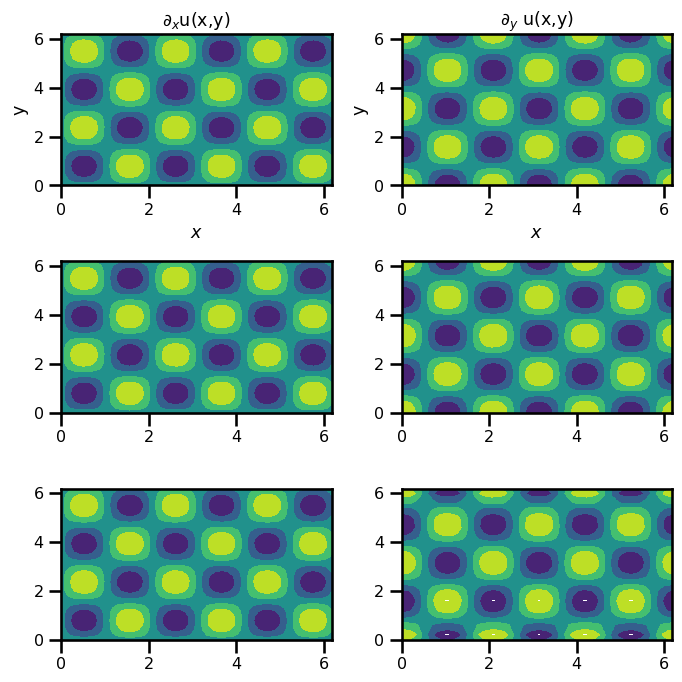

In [174]:
fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(7,7))

x_levels = np.linspace(dudx[:].min(), dudx[:].max(), 6)
y_levels = np.linspace(dudy[:].min(), dudy[:].max(), 6)


ax[0,0].contourf(X, Y, dudx[:], levels=x_levels)
ax[0,1].contourf(X, Y, dudy[:], levels=y_levels)

X, Y = dudx_fd.domain.grid_axis

ax[1,0].contourf(X, Y, dudx_fd[:], levels=x_levels)
ax[1,1].contourf(X, Y, dudy_fd[:], levels=y_levels)

X, Y = dudx_spectral.domain.grid_axis

ax[2,0].contourf(X, Y, dudx_spectral[:], levels=x_levels)
ax[2,1].contourf(X, Y, dudy_spectral[:], levels=y_levels)

ax[0,0].set(title="$\partial_x $u(x,y)", xlabel="$x$", ylabel=r"y")
ax[0,1].set(title="$\partial_y$ u(x,y)", xlabel="$x$", ylabel="y")
plt.tight_layout()
plt.show()

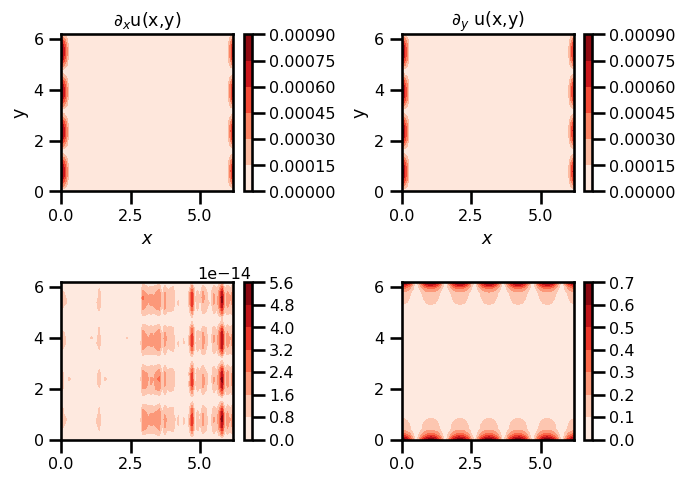

In [175]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(7,5))

fd_err_x = np.abs(dudx[:] - dudx_fd[:])
fd_err_y = np.abs(dudy[:] - dudy_fd[:])

pts=ax[0,0].contourf(X, Y, fd_err_x, cmap="Reds")
plt.colorbar(pts)
pts=ax[0,1].contourf(X, Y, fd_err_x, cmap="Reds")
plt.colorbar(pts)

ps_err_x = np.abs(dudx[:] - dudx_spectral[:])
ps_err_y = np.abs(dudy[:] - dudy_spectral[:])

pts=ax[1,0].contourf(X, Y, ps_err_x, cmap="Reds")
plt.colorbar(pts)
pts=ax[1,1].contourf(X, Y, ps_err_y, cmap="Reds")
plt.colorbar(pts)

ax[0,0].set(title="$\partial_x $u(x,y)", xlabel="$x$", ylabel=r"y")
ax[0,1].set(title="$\partial_y$ u(x,y)", xlabel="$x$", ylabel="y")
plt.tight_layout()
plt.show()

## Example 3: 2D Vector Field

In [87]:
x_domain = init_domain_1d(-1.0, 1.0, 50)

xy_domain = x_domain * x_domain

u_f = lambda x, y: -y #x**2 + y**2 # 
v_f = lambda x, y:  +x #x**4 + y**3 #
def init_u(domain: Domain) -> jax.Array:
    # grab meshgrid coords
    x, y = domain.coords_axis
    u = gram_matrix(u_f, x, y)
    return u

def init_v(domain: Domain) -> jax.Array:
    # grad meshgrid coords
    x, y = domain.coords_axis
    v = gram_matrix(v_f, x, y)
    return v

In [88]:
from jaxsw._src.fields.base import Field
u = Field.init_from_fn(xy_domain, init_u, xy_domain)
v = Field(domain=xy_domain, values=init_v(xy_domain))

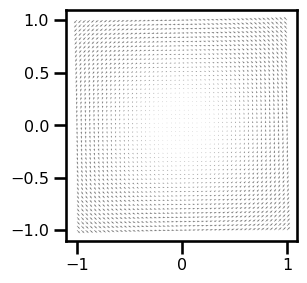

In [89]:
fig, ax = plt.subplots(figsize=(7, 3))

ax.quiver(xy_domain.grid_axis[0], xy_domain.grid_axis[1], u.values, v.values, color="k", alpha=0.5)

ax.set_aspect("equal", "box")
plt.show()

### Finite Difference

For a 2D function, $\boldsymbol{f}(x,y)$, the partial derivative is:

$$
\partial_x \boldsymbol{f}(\mathbf{x},\mathbf{y}) =
\lim_{\epsilon\rightarrow 0} \frac{\boldsymbol{f}(\mathbf{x}+\epsilon,\mathbf{y})-
\boldsymbol{f}(\mathbf{x},\mathbf{y})}{\epsilon}
$$

For discrete data, we can approximate this using finite differences:

$$
\partial_x f(x,y) \approx \frac{f(x+1,y)-f(x,y)}{1}
$$

In [77]:
# F1/dx: differentiate F1 wrt x
du_dx = fdx.difference(u.values, axis=0, step_size=u.domain.dx[0], accuracy=10, method="central")

dv_dy = fdx.difference(v.values, axis=1, step_size=v.domain.dx[1], accuracy=10, method="central")

du_dx.shape, dv_dy.shape

((50, 50), (50, 50))

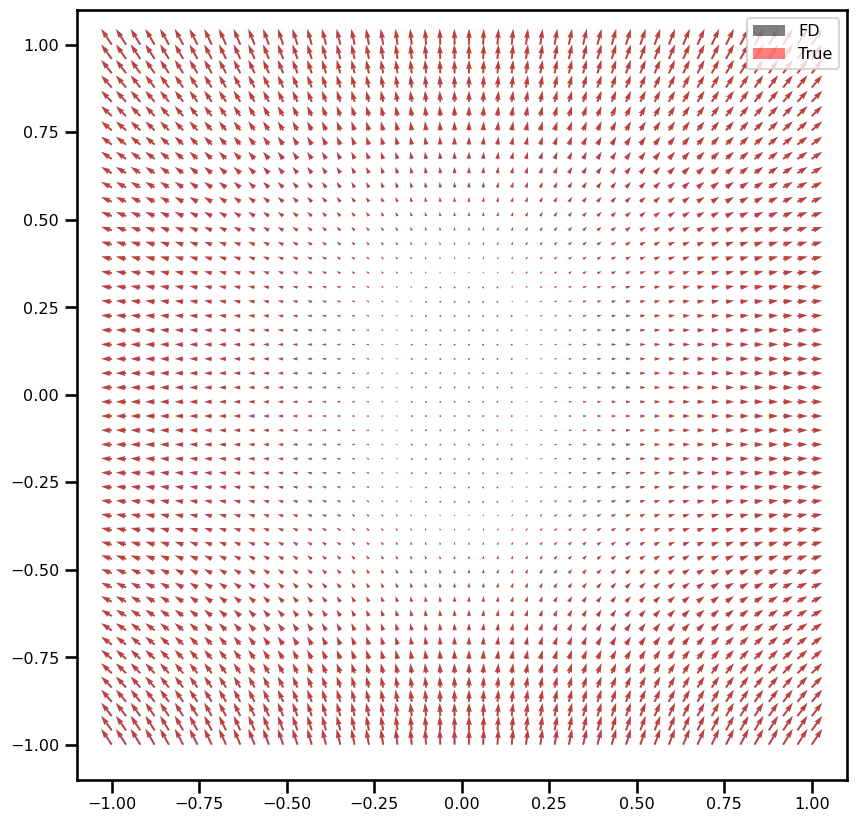

In [78]:
fig, ax = plt.subplots(figsize=(10, 10))

X, Y = u.domain.grid_axis

ax.quiver(X, Y, du_dx, dv_dy, color="k", alpha=0.5, label="FD")
ax.quiver(X, Y, 2 * X, 3 * Y**2, color="red", alpha=0.5, label="True")

plt.legend()
ax.set_aspect("equal", "box")
plt.show()

In [79]:
from jaxsw._src.operators.functional import arakawac as C_grid
from jaxsw._src.operators.functional import interp as F_interp

In [97]:
domain = init_domain_1d(-1.0, 1.0, 50)

domain = domain * domain

u_domain = C_grid.stagger_domain(domain, direction=("right", None), stagger=(True, False))
v_domain = C_grid.stagger_domain(domain, direction=(None, "right"), stagger=(False, True))

u = Field.init_from_fn(u_domain, init_u, u_domain)
v = Field.init_from_fn(v_domain, init_v, v_domain)
u.domain, v.domain

(-1.0, -1.0) (1.0, 1.0) (0.04081632653061224, 0.04081632653061224)
(-0.9795918367346939, -1.0) (1.0204081632653061, 1.0) (0.04081632653061224, 0.04081632653061224)
(-1.0, -1.0) (1.0, 1.0) (0.04081632653061224, 0.04081632653061224)
(-1.0, -0.9795918367346939) (1.0, 1.0204081632653061) (0.04081632653061224, 0.04081632653061224)


(Domain(
   xmin=(-0.9795918367346939, -1.0),
   xmax=(1.0204081632653061, 1.0),
   dx=(0.04081632653061224, 0.04081632653061224),
   Nx=(50, 50),
   Lx=(2.0, 2.0),
   ndim=2
 ),
 Domain(
   xmin=(-1.0, -0.9795918367346939),
   xmax=(1.0, 1.0204081632653061),
   dx=(0.04081632653061224, 0.04081632653061224),
   Nx=(50, 50),
   Lx=(2.0, 2.0),
   ndim=2
 ))

In [98]:
du_dx = C_grid.difference(u, axis=0)
dv_dy = C_grid.difference(v, axis=1)

(50, 50) (50, 50)
(-0.9795918367346939, -1.0) (1.0204081632653061, 1.0) (0.04081632653061224, 0.04081632653061224)
(-0.9591836734693877, -1.0) (1.0, 1.0) (0.04081632653061224, 0.04081632653061224)
(49, 50) (49, 50)
(50, 50) (50, 50)
(-1.0, -0.9795918367346939) (1.0, 1.0204081632653061) (0.04081632653061224, 0.04081632653061224)
(-1.0, -0.9591836734693877) (1.0, 1.0) (0.04081632653061224, 0.04081632653061224)


In [99]:
du_dx, F_interp.field_domain_transform(dv_dy, du_dx.domain)

(Field(
   values=f64[49,50],
   domain=Domain(
     xmin=(-0.9591836734693877, -1.0),
     xmax=(1.0, 1.0),
     dx=(0.04081632653061224, 0.04081632653061224),
     Nx=(49, 50),
     Lx=(1.9591836734693877, 2.0),
     ndim=2
   )
 ),
 Field(
   values=f64[49,50],
   domain=Domain(
     xmin=(-0.9591836734693877, -1.0),
     xmax=(1.0, 1.0),
     dx=(0.04081632653061224, 0.04081632653061224),
     Nx=(49, 50),
     Lx=(1.9591836734693877, 2.0),
     ndim=2
   )
 ))

In [83]:
du_dx.values.min(), du_dx.values.max()

(Array(-1.91836735, dtype=float64), Array(2., dtype=float64))

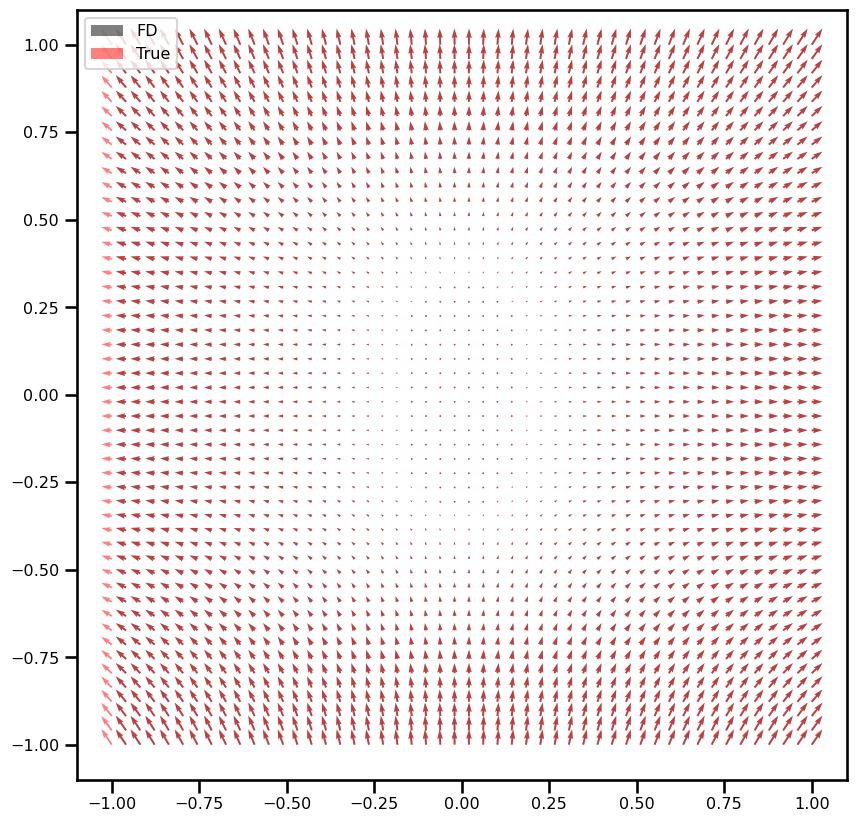

In [96]:
fig, ax = plt.subplots(figsize=(10, 10))

X_, Y_ = du_dx.domain.grid_axis

ax.quiver(X_, Y_, du_dx.values, F_interp.field_domain_transform(dv_dy, du_dx.domain).values, color="k", alpha=0.5, label="FD")
ax.quiver(X, Y, 2 * X, 3 * Y**2, color="red", alpha=0.5, label="True")

plt.legend()
ax.set_aspect("equal", "box")
plt.show()

### Pseudospectral

In [90]:
k_vec_u = [calculate_fft_freq(Nx=Nx, Lx=Lx) for Nx, Lx in zip(u.domain.Nx, u.domain.Lx)]
k_vec_v = [calculate_fft_freq(Nx=Nx, Lx=Lx) for Nx, Lx in zip(v.domain.Nx, v.domain.Lx)]

In [91]:
# forward transformation
Fu_x = fft_transform(u.values, axis=0, scale=u.domain.Nx[0], inverse=False)
Fu_y = fft_transform(v.values, axis=1, scale=v.domain.Nx[1], inverse=False)

# difference operator
dFudx = difference(Fu_x, k_vec_u[0], axis=0, derivative=1)
dFudy = difference(Fu_y, k_vec_v[1], axis=1, derivative=1)

# # inverse transformation
dudx_sp = fft_transform(dFudx, axis=0, scale=u.domain.Nx[0], inverse=True)
dudy_sp = fft_transform(dFudy, axis=1, scale=v.domain.Nx[1], inverse=True)

dudx_sp = jnp.real(dudx_sp)
dudy_sp = jnp.real(dudy_sp)

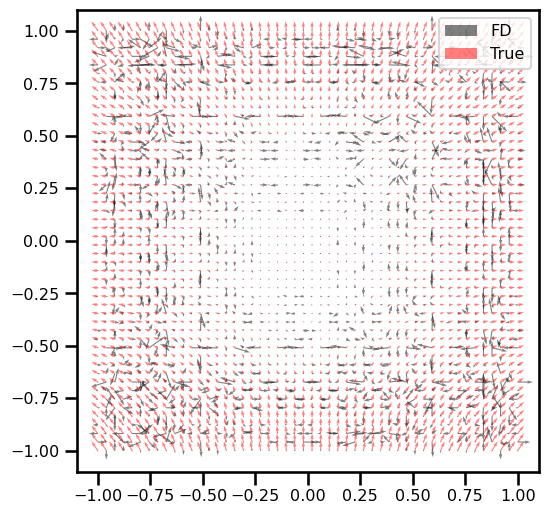

In [95]:
fig, ax = plt.subplots(figsize=(7, 6))

X, Y = u.domain.grid_axis

ax.quiver(X, Y, dudx_sp, dudy_sp, color="k", alpha=0.5, label="FD")
ax.quiver(X, Y, 2 * X, 3 * Y**2, color="red", alpha=0.5, label="True")

plt.legend()
ax.set_aspect("equal", "box")
plt.show()